In [456]:
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
import sklearn.preprocessing
from scipy.misc import logsumexp
import random as r
import scipy.misc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import random
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Использованные материалы:
    1) http://deeplearning.net/tutorial/rbm.html
    2) https://habrahabr.ru/post/159909/
    3) https://pdfs.semanticscholar.org/19a5/6027227690f7301494e94621f4486225e813.pdf
    4) https://arxiv.org/pdf/1401.5900v1.pdf
    5) https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf

In [4]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

# generate the next binary vector
def inc(x):
    for i in xrange(len(x)):
        x[i] += 1
        if x[i] <= 1: return True
        x[i] = 0
    return False

In [186]:
class RBM(object):
    def __init__(self, 
                cnt_visible = 100,
                cnt_hidden = 100,
                units_type = "BB" #first letter - type visible units, second letter - type hidden units  
                ):
        self.cnt_visible = cnt_visible
        self.cnt_hidden = cnt_hidden
        
        self.weights = np.random.normal(0, 0.01, (cnt_visible, cnt_hidden))
        self.vbias = np.zeros(shape = (1, cnt_visible))
        self.hbias = np.zeros(shape = (1, cnt_hidden))
        self.hidden = None
        self.visible= None
        self.input_data = None
        self.momentum = 0
        self.units_type = units_type
        self.sigma_sqr = np.empty(shape = (1, cnt_visible))
        self.sigma_sqr.fill(0.01)
        
    #sigmoid(W * visible_layer + hidden_bias)
    def forward_pass(self):
        self.hidden = sigmoid(np.dot(self.visible, self.weights) + self.hbias)
    
    #sigmoid(W.T * hidden_layer + visible_bias)
    def backward_pass(self):
        if self.units_type == "BB":
            self.visible = sigmoid(np.dot(self.hidden, self.weights.T) + self.vbias)
            
        if self.units_type == "GB":
            raw_visible = np.dot(self.hidden, self.weights.T) + self.vbias
            for unit in xrange(self.visible.shape[1]):
                for sample in xrange(self.visible.shape[0]):
                    self.visible[sample, unit] = np.random.normal(raw_visible[sample, unit],\
                                                                  np.sqrt(self.sigma_sqr[0, unit]) + 0.1e-6, 1)

    def sampling_hid_given_vis(self):
        for row in xrange(self.hidden.shape[0]):
            for col in xrange(self.hidden.shape[1]):
                self.hidden[row, col] = np.random.binomial(1, self.hidden[row, col], 1)

    def sampling_vis_given_hid(self):
        for row in xrange(self.visible.shape[0]):
            for col in xrange(self.visible.shape[1]):
                self.visible[row, col] = np.random.binomial(1, self.visible[row, col], 1)
    
    def sampling_v_h_v(self):
        self.forward_pass()
        self.sampling_hid_given_vis()
        self.backward_pass()
        #self.sampling_vis_given_hid()
    
    def gibbs_sampling(self):
        inp = self.visible 
        #first interation of sampling
        self.sampling_v_h_v()
        if self.units_type == "BB":
            self.pos_phase_weights = inp.T.dot(self.hidden) / float(self.visible.shape[0])  #normalize for batch_size
            self.pos_phase_vbias = inp.mean(axis = 0)
            self.pos_phase_hbias = self.hidden.mean(axis = 0)
        if self.units_type == "GB":
            self.pos_phase_weights = (inp * (1 / (self.sigma_sqr + 0.1e-7))).T.dot(self.hidden) / float(self.visible.shape[0])  #normalize for batch_size
            self.pos_phase_vbias = (inp * (1 / (self.sigma_sqr + 0.1e-7))).mean(axis = 0)
            self.pos_phase_hbias = self.hidden.mean(axis = 0)
            self.pos_phase_log_sqr_sigma = ((1.0 / 2) * (inp - self.vbias)**2 - \
                                            (inp * (self.hidden).dot(self.weights.T).mean(axis = 0)))
        
        for k in range(self.sampling_param - 1):
            self.sampling_v_h_v()
        
        #last iteration of sampling
        self.forward_pass()
        
#         print "last hidden ", self.hidden
        if self.units_type == "BB":
            self.neg_phase_weights = self.visible.T.dot(self.hidden) / float(self.visible.shape[0])  #normalize for batch_size
            self.neg_phase_vbias = self.visible.mean(axis = 0)
            self.neg_phase_hbias = self.hidden.mean(axis = 0)
        if self.units_type == "GB":
            self.neg_phase_weights = (self.visible * (1.0 / (self.sigma_sqr + 0.1e-6))).T.dot(self.hidden)\
                                    / float(self.visible.shape[0])  #normalize for batch_size
            self.neg_phase_vbias = (self.visible * (1.0 / (self.sigma_sqr + 0.01e-6))).mean(axis = 0)
            self.neg_phase_hbias = self.hidden.mean(axis = 0)
            self.neg_phase_log_sqr_sigma = ((1.0 / 2) * (inp - self.vbias)**2 - \
                                            (self.visible * (self.hidden).dot(self.weights.T).mean(axis = 0)))                                

    def update_param(self):
        
        delta_weights = self.momentum * (self.last_delta_weights) + (self.pos_phase_weights - self.neg_phase_weights)
        delta_vbias = self.momentum * (self.last_delta_vbias) + (self.pos_phase_vbias - self.neg_phase_vbias)
        delta_hbias = self.momentum * (self.last_delta_hbias) + (self.pos_phase_hbias - self.neg_phase_hbias)
        
#         print "delta_weights \n", delta_weights
        self.weights += self.learning_ratio * delta_weights
        self.vbias += self.learning_ratio * delta_vbias
        self.hbias += self.learning_ratio * delta_hbias
        if self.units_type == "GB":
            try:
                delta_log_sigma_sqr = np.exp(-1 * np.log(self.sigma_sqr+ 0.0e-6)) * self.momentum * (self.last_delta_log_sqr_sigma)\
                                            + (self.pos_phase_log_sqr_sigma - self.neg_phase_log_sqr_sigma)
            except:
                delta_log_sigma_sqr = 0.1e-6 * self.momentum * (self.last_delta_log_sqr_sigma)\
                                            + (self.pos_phase_log_sqr_sigma - self.neg_phase_log_sqr_sigma)
            
            try:
                self.sigma_sqr = np.exp(np.log(self.sigma_sqr + 0.0e-6) + delta_log_sigma_sqr)
            except:
                self.sigma_sqr = 0.1e-6
            self.last_delta_log_sqr_sigma = delta_log_sigma_sqr
                                            
         
        self.last_delta_weights = delta_weights
        self.last_delta_vbias = delta_vbias
        self.last_delta_hbias = delta_hbias
        
        
    def energy_bin_bin(self, visible, hidden):
        weights_part = np.dot(visible.dot(self.weights), hidden)
#         print self.vbias
#         print visible
        vis_part = self.vbias.dot(visible)
        hid_part = self.hbias.dot(hidden)
        return (-weights_part - vis_part - hid_part)
    
    #calculate normalizing constant
    def calc_log_normalizing_const(self):
        x = np.zeros(shape = self.cnt_visible)
        h = np.zeros(shape = self.cnt_hidden)
        energy_array = []
        while True:
            while True:
                energy_array.append(-1 * self.energy_bin_bin(x,h))
                if not inc(h): 
                    break
            if not inc(x): 
                break  
            
        return logsumexp(np.asarray(energy_array))
    
    def log_likelihood(self, batch):
        LogLikelihood = 0
        log_Z = self.log_normalizing_const
        for X in batch:
            energy_array = []
            h = np.zeros(shape = self.cnt_hidden)
            while True: #sum over all possible values of h
                energy_array.append(self.energy_bin_bin(X,h))
                if not inc(h): break
                    
            LogLikelihood += logsumexp(np.asarray(energy_array)) - log_Z
            
        return LogLikelihood / float(batch.shape[0])
        
    
    def fit(self, X,
            learning_ratio = 0.1, 
            batch_size = 40, 
            training_epochs = 100,
            sampling_param = 4, 
            momentum = 0, 
            verbose = "LogLikelihood"):
        
        self.sampling_param = sampling_param
        self.momentum = momentum
        self.learning_ratio = learning_ratio
    
        self.last_delta_weights = np.zeros(shape = (self.cnt_visible, self.cnt_hidden))
        self.last_delta_vbias = np.zeros(shape = (1, self.cnt_visible))
        self.last_delta_hbias = np.zeros(shape = (1, self.cnt_hidden))
        self.last_delta_log_sqr_sigma = np.zeros(shape = (1, self.cnt_visible))
                                            
        if verbose == "LogLikelihood":
            self.log_normalizing_const = self.calc_log_normalizing_const()
        
        for epoch in range(training_epochs):
            
            batch_samples = r.sample(xrange(X.shape[0]), batch_size)  
            
            self.input_data = X[batch_samples] 
            self.visible = X[batch_samples]
            self.gibbs_sampling()
            self.update_param()
            
            if epoch % 100 == 0: 
                print "Training epoch:" , epoch
                if verbose == 'LogLikelihood':
#                 print "likelihood visible vector", self.visible.mean(axis = 0)
                  print "Log likelihood: ", self.log_likelihood(X[batch_samples])
                if verbose == 'MSE':
#                 print "likelihood visible vector", self.visible.mean(axis = 0)
                  print "MSE distance between input and reconstruction:",\
                        ((X[batch_samples] - self.reconstruct(X[batch_samples])) ** 2).mean(axis=1).mean()
#                 print self.pos_phase_weights
#                 print self.neg_phase_weights
#             print "---------------------------------------------------------"
    def reconstruct(self, X):
        #hid = X.dot(self.weights)
        self.visible = X
        self.sampling_v_h_v()
        self.sampling_vis_given_hid()
        return self.visible
        
        
    
        
        

In [171]:
print 0.1e-6 + 1

1.0000001


In [160]:
simple_train =np.array([[0, 0.]] * 50 + [[1, 1.0]] * 50)
AND_model = RBM(cnt_visible = 2, cnt_hidden = 1)

print "Before train:"
print "Weights: \n", AND_model.weights
print "Bias Visible Layer: \n", AND_model.vbias
print "Bias hidden Layer: \n", AND_model.hbias
print "_______________________________________"

AND_model.fit(simple_train, learning_ratio = 0.1, batch_size = 50, \
              training_epochs = 2000,momentum=0.7, sampling_param=3)
print "_______________________________________"
print "After train:"

print "Weights: \n", AND_model.weights
print "Bias Visible Layer: \n", AND_model.vbias
print "Bias hidden Layer: \n", AND_model.hbias 
print "_______________________________________"

AND_model.reconstruct(np.asarray([[0, 0], [1, 1], [1, 0], [0, 1]]))



Before train:
Weights: 
[[-0.00040864]
 [-0.0100266 ]]
Bias Visible Layer: 
[[ 0.  0.]]
Bias hidden Layer: 
[[ 0.]]
_______________________________________
Training epoch: 0
Log likelihood:  -1.38986358969
Training epoch: 100
Log likelihood:  -1.25162004423
Training epoch: 200
Log likelihood:  0.507077874221
Training epoch: 300
Log likelihood:  1.97715007004
Training epoch: 400
Log likelihood:  2.93238064041
Training epoch: 500
Log likelihood:  3.45569661115
Training epoch: 600
Log likelihood:  3.86528110748
Training epoch: 700
Log likelihood:  4.20839248499
Training epoch: 800
Log likelihood:  4.48546428536
Training epoch: 900
Log likelihood:  4.60658874309
Training epoch: 1000
Log likelihood:  4.88633326511
Training epoch: 1100
Log likelihood:  5.0858468069
Training epoch: 1200
Log likelihood:  5.11465891956
Training epoch: 1300
Log likelihood:  5.22931230858
Training epoch: 1400
Log likelihood:  5.51152854245
Training epoch: 1500
Log likelihood:  5.44553213056
Training epoch: 1600
L

array([[ 0.,  0.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 0.,  0.]])

In [183]:
simple_train =np.array([[0.5, 0.5]] * 50 + [[1.5, 1.5]] * 50)
AND_model = RBM(cnt_visible = 2, cnt_hidden = 1, units_type="GB")

print "Before train:"
print "Weights: \n", AND_model.weights
print "Bias Visible Layer: \n", AND_model.vbias
print "Bias hidden Layer: \n", AND_model.hbias
print "_______________________________________"

AND_model.fit(simple_train, learning_ratio = 0.05, batch_size = 50, \
              training_epochs = 2000,momentum=0.5, sampling_param=3, verbose = "")
print "_______________________________________"
print "After train:"

print "Weights: \n", AND_model.weights
print "Bias Visible Layer: \n", AND_model.vbias
print "Bias hidden Layer: \n", AND_model.hbias 
print "_______________________________________"

AND_model.reconstruct(np.asarray([[0.5, 0.5], [1.5, 1.5], [1, 1], [0, 0]]))



Before train:
Weights: 
[[-0.00076723]
 [ 0.01534391]]
Bias Visible Layer: 
[[ 0.  0.]]
Bias hidden Layer: 
[[ 0.]]
_______________________________________
[[ 0.01  0.01]]
[[ 0.01  0.01]]
[[ 0.01  0.01]]
Training epoch: 0
[[ 0.00999897  0.01017592]
 [ 0.00995572  0.0100423 ]
 [ 0.01002599  0.00997643]
 [ 0.00999535  0.01006372]
 [ 0.01002045  0.01001617]
 [ 0.01002189  0.01002227]
 [ 0.01004755  0.01008321]
 [ 0.01008278  0.00999624]
 [ 0.01004786  0.0099366 ]
 [ 0.01001135  0.00994945]
 [ 0.01008939  0.01007901]
 [ 0.00996436  0.00999383]
 [ 0.0099971   0.01004315]
 [ 0.0098051   0.01000425]
 [ 0.00994772  0.0100385 ]
 [ 0.0101493   0.00998762]
 [ 0.01005495  0.00999503]
 [ 0.01006072  0.01007637]
 [ 0.0100105   0.01006152]
 [ 0.01012146  0.00998536]
 [ 0.01000442  0.01000082]
 [ 0.01000103  0.01008046]
 [ 0.00977573  0.01000005]
 [ 0.01015379  0.01000327]
 [ 0.01002654  0.00996884]
 [ 0.01012678  0.00993048]
 [ 0.00988993  0.01000871]
 [ 0.00999389  0.00973486]
 [ 0.01011016  0.01030

/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:101: RuntimeWarning: overflow encountered in exp
/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in multiply
/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in multiply
/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:79: RuntimeWarning: invalid value encountered in multiply
/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:80: RuntimeWarning: invalid value encountered in multiply
/home/dana_zl/anaconda2/lib/python2.7/site-packages/ipy

ValueError: p is nan

### Обучение совместному распределению

In [128]:
a = np.empty(3)
a.fill(0.01)
print a

[ 0.01  0.01  0.01]


In [90]:
train_data = np.zeros(shape = (5, 200))
p = 0.0
for i in range(train_data.shape[0]):
    for j in range(200):
        train_data[i, j] = np.random.binomial(1, p, 1)
    p += 0.1
print train_data.T[:10]

[[ 0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]]


In [92]:
Distr_model = RBM(cnt_visible = 5, cnt_hidden = 10)

print "Before train:"
print "Weights: \n", Distr_model.weights
print "Bias Visible Layer: \n", Distr_model.vbias
print "Bias hidden Layer: \n", Distr_model.hbias
print "_______________________________________"

Distr_model.fit(train_data.T, learning_ratio = 0.1, batch_size = 40, training_epochs = 2000,momentum=0.5,\
                sampling_param=2)
print "_______________________________________"
print "After train:"
print "Weights: \n", Distr_model.weights
print "Bias Visible Layer: \n", Distr_model.vbias
print "Bias hidden Layer: \n", Distr_model.hbias 
print "_______________________________________"

Distr_model.reconstruct([[1, 0, 0, 1, 1]])

Before train:
Weights: 
[[ 0.02709734 -0.00504745 -0.00548904  0.01755138  0.01703963 -0.00276515
   0.01576412 -0.01696579  0.0033809  -0.00166291]
 [ 0.00593439  0.01890649  0.01405652  0.00123233  0.00294821 -0.00598763
  -0.00963271 -0.01304486  0.01125496 -0.02521294]
 [ 0.00970739  0.01259536 -0.01119132 -0.01745944 -0.00314812  0.01086695
  -0.01024939 -0.00613723 -0.00393937 -0.01762774]
 [ 0.01357201  0.0041056   0.0043574   0.00256579  0.00457118 -0.01311578
   0.01034164  0.01337641 -0.00891955 -0.00353465]
 [ 0.01997644  0.00361872  0.01314067 -0.00451478  0.00186108  0.0051605
   0.00350178 -0.00710323 -0.00576925 -0.00013507]]
Bias Visible Layer: 
[[ 0.  0.  0.  0.  0.]]
Bias hidden Layer: 
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
_______________________________________
Training epoch: 0
Log likelihood:  -3.40969010491
Training epoch: 100
Log likelihood:  -3.33777998018
Training epoch: 200
Log likelihood:  -3.03050133767
Training epoch: 300
Log likelihood:  -2.04504907

array([[ 0.,  1.,  0.,  1.,  1.]])

## DBN

In [386]:
def soft_softmax(x):
    x = np.array([x[i] - np.max(x[i]) for i in xrange(x.shape[0])])
    x = np.array([np.exp(x[i]) / np.sum(np.exp(x[i])) for i in xrange(x.shape[0])])
    return x

def activate(activate, x):
    if activate == 'sigmoid':
        return (1 / (1 + np.exp(-x)))
    elif activate == 'tanh':
        return np.tanh(x)
    elif activate == 'softmax':
        return soft_softmax(x)
    elif activate == 'ReLU':
        for i in xrange(x.shape[0]):
            for j in xrange(x.shape[1]):
                if (x[i][j] < 0):
                    x[i][j] = 0
        return x 
    
def deriv_activ(activate, x):
    if activate == 'sigmoid':
        return x * (1 - x)
    elif activate == 'tanh':
        return (1.0 - x**2)  
    elif activate == 'softmax':
        return x * (1 - x)
    elif activate == 'ReLU':
        for i in xrange(x.shape[0]):
            for j in xrange(x.shape[1]):
                if (x[i][j] < 0):
                    x[i][j] = 0
                else:
                    x[i][j] = 1
        return x 

In [396]:
class Layer:
    def __init__(self, num_nodes, prev_num_nodes = -1, bias = True, activate = "sigmoid"):
        self.num_nodes = num_nodes
        self.prev_num_nodes = prev_num_nodes
        self.need_bias = bias;
        print self.need_bias
        if (self.need_bias):
            self.bias = 2 * np.random.random((1, num_nodes)) - 1
        self.weights_matrix = None
        self.activate = activate

    def forward_pass(self, X):
        if (self.weights_matrix is None) and (self.prev_num_nodes != 1):
            self.weights_matrix = 2*np.random.random((self.prev_num_nodes, self.num_nodes)) - 1

        if (self.need_bias):
            self.Y = activate(self.activate, np.dot(X, self.weights_matrix) + self.bias)
        else:
            self.Y = activate(self.activate, np.dot(X, self.weights_matrix))
        
        return self.Y
    
    def backward_pass(self, WeightedGradientNextLayer, learning_ratio, Y_prev): 
        #calculate gradient and update weights
        Delta = WeightedGradientNextLayer * deriv_activ(self.activate, self.Y)
        Gradient = Y_prev.T.dot(Delta)
        #print "Gradient 0: " + str(Gradient)
        self.weights_matrix -= learning_ratio * Gradient
        
        if (self.need_bias):
            self.bias -= learning_ratio * Delta.mean(0)
        
        return (Delta.dot(self.weights_matrix.T))
    
class OutputLayer(Layer):
    def backward_begin (self, loss_function, OUT, learning_ratio, Y_prev):
        
        if loss_function == "MSE":
            Delta = -1 *(OUT - self.Y) * deriv_activ(self.activate, self.Y)
            Gradient = Y_prev.T.dot(Delta)
            Error = (((OUT - self.Y)**2).mean(axis = 1)).mean()
            #print "Gradient" + str(Gradient)
            try:
                self.weights_matrix -= learning_ratio * Gradient
            except:
                print OUT.shape, self.Y.shape, Delta.shape, Y_prev.shape
            if (self.need_bias):
                #print "bias", self.bias
                #print "delta", Delta.sum()
                self.bias -= learning_ratio * Delta.mean(0)
            
            
        elif loss_function == "NLL":
            
            Error = -1 * (OUT * np.log(self.Y)).sum()
            
            #print self.Y
            Delta = (self.Y - OUT)
            Gradient = Y_prev.T.dot(Delta)
            #print "Gradient: " + str(Gradient[0])
            self.weights_matrix -= learning_ratio * Gradient
            if (self.need_bias):
                #print self.bias
                #print Delta.sum()
                self.bias -= learning_ratio * Delta.mean(0)
        
        return Delta.dot(self.weights_matrix.T), Error
    
    
class InputLayer(Layer):
    def forward_begin (self, X):
        self.Y = X
        
        return self.Y
        
        

In [486]:
class DBN:
    def __init__(self, layers):
        self.layers = layers
        
    def fit(self, X, OUT, batch_size, iteration, learning_ratio, loss_function, RBM_initialize = True):
        
        if (RBM_initialize):
            X_RBM = np.copy(X)
            for layer in xrange(1, len(self.layers)):
                print "____________________________________________________________"
                print "Train weights betweeen layer %i and layer %i" %(layer - 1, layer)
                rbm_model = RBM(cnt_visible = self.layers[layer].prev_num_nodes, cnt_hidden = self.layers[layer].num_nodes)

                rbm_model.fit(X_RBM, learning_ratio = 0.08, batch_size = 30, \
                              training_epochs = 2000, momentum=0.6, sampling_param=3, 
                                 verbose = "MSE")

                self.layers[layer].weights_matrix = rbm_model.weights
                self.layers[layer].bias = rbm_model.hbias
                
                self.visible = X_RBM
                rbm_model.forward_pass()
                rbm_model.sampling_hid_given_vis()
                X_RBM = rbm_model.hidden
#                 #print layer, self.layers[layer].weights_matrix, self.layers[layer].bias
#                 if (self.layers[layer].need_bias):
#                     X_RBM = activate(self.layers[layer].activate, \
#                                      np.dot(X_RBM, self.layers[layer].weights_matrix) + self.layers[layer].bias)
#                 else:
#                     X_RBM = activate(self.layers[layer].activate, np.dot(X_RBM, self.layers[layer].weights_matrix))

                
            
        for iterat in xrange(iteration):
            
            batch_sample = r.sample(xrange(X.shape[0]), batch_size)                
            #batch_sample = xrange(batch_size)
            
            self.layers[0].forward_begin(X[batch_sample])
            
            for i in xrange(1, len(self.layers)):
                self.layers[i].forward_pass(self.layers[i - 1].Y)
    
            WeightedGradientNextLayer_tmp, Error = self.layers[len(self.layers) - 1].backward_begin(loss_function,\
                                                        OUT[batch_sample], learning_ratio, \
                                                        self.layers[len(self.layers) - 2].Y)
        
            for i in xrange(len(self.layers) - 2, 0, -1):
                WeightedGradientNextLayer_tmp = self.layers[i].backward_pass(WeightedGradientNextLayer_tmp, \
                                                                       learning_ratio, self.layers[i - 1].Y)
            
            right_cnt = 0
            if iterat % 100 == 0:
                print "________________________________________________"
                print "Iteration: " + str(iterat)
                print 'Error: '  + str(Error)
                #print "Y_i: " + str(np.argmax(self.layers[len(self.layers) - 1].Y[0]))
                #print "OUT: " + str(np.argmax(OUT[batch_sample[0]]))
                if loss_function == 'NLL':
                    for i in xrange(batch_size):
                        if np.argmax(self.layers[len(self.layers) - 1].Y[i]) == np.argmax(OUT[batch_sample[i]]):
                            right_cnt += 1

                    print "True identified: " + str(right_cnt) + "|" + str(batch_size)
            
                
    
    def predict(self, X):
        self.layers[0].forward_begin(X)
        for i in xrange(1, len(self.layers)):
            self.layers[i].forward_pass(self.layers[i - 1].Y)
        
        if self.layers[len(self.layers) - 1].activate == 'softmax':
            self.layers[len(self.layers) - 1].Y = soft_softmax(self.layers[len(self.layers) - 1].Y)
        return self.layers[len(self.layers) - 1].Y
                
                

In [384]:
print "%i   %i" %(1, 2)

1   2


## Сравнение DBN и простого Backpropagation

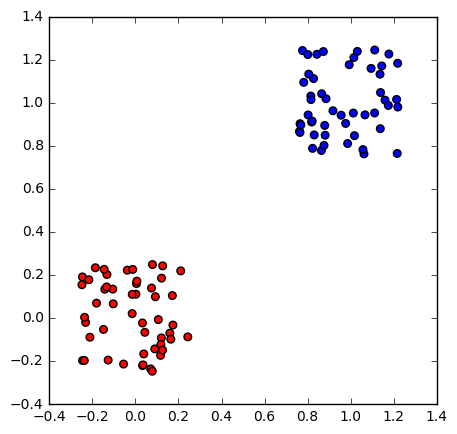

True
True
________________________________________________
Iteration: 0
Error: 0.306467761636
________________________________________________
Iteration: 100
Error: 0.0874902568051
________________________________________________
Iteration: 200
Error: 0.0738273434405
________________________________________________
Iteration: 300
Error: 0.057131026899
________________________________________________
Iteration: 400
Error: 0.0380507481214
________________________________________________
Iteration: 500
Error: 0.0439803243152
[[ 2.24434424]
 [ 1.84881607]]
[[-1.19838414]]
[[ 0.22487188]
 [ 0.22273066]
 [ 0.13914016]
 [ 0.35911171]
 [ 0.29194733]
 [ 0.13929421]
 [ 0.25118415]
 [ 0.17775659]
 [ 0.26885372]
 [ 0.12748347]
 [ 0.34144619]
 [ 0.43680827]
 [ 0.36452923]
 [ 0.21658044]
 [ 0.1575596 ]
 [ 0.27433311]
 [ 0.15418639]
 [ 0.34434886]
 [ 0.21637324]
 [ 0.23917759]
 [ 0.9487206 ]
 [ 0.96709884]
 [ 0.95222004]
 [ 0.91808668]
 [ 0.94905331]
 [ 0.90963551]
 [ 0.97241373]
 [ 0.94418859]
 [ 0.

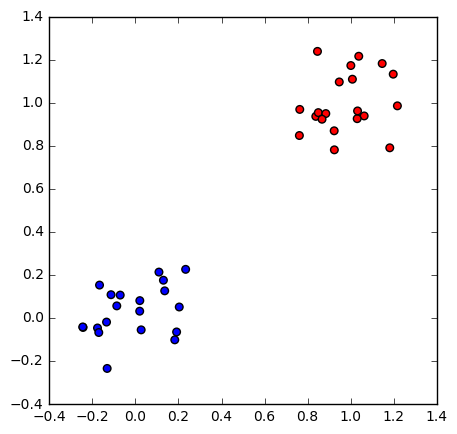

In [493]:
#WITHOUT RBM

simple_train =np.array([[0.0, 0.0]] * 50 + [[1, 1.0]] * 50)
simple_check = np.array([[0.0]] * 50 + [[1.0]] * 50)

for i in xrange(len(simple_train)):
    (simple_train[i])[0] += np.random.sample() / 2 - 0.25
    (simple_train[i])[1] += np.random.sample() / 2 - 0.25
    
#на этих данных буду обучать
plt.figure(figsize = (5, 5))
plt.scatter(simple_train[:, 0], simple_train[:, 1],s = 30, \
            c = ['r' if simple_check[i][0] == 0 else 'b' for i in xrange(len(simple_check))])
plt.show() 

Layer1 = InputLayer(num_nodes = 2, bias = True)
Layer2 = OutputLayer(num_nodes = 1, prev_num_nodes = 2,bias = True,activate = 'sigmoid')

simple_model = DBN([Layer1, Layer2])
simple_model.fit(simple_train, simple_check, 20, 600, learning_ratio = 0.05,\
                 loss_function = "MSE", RBM_initialize = False)

print Layer2.weights_matrix
print Layer2.bias

#на этих тестировать 
simple_test =np.array([[0.0, 0]] * 20 + [[1, 1.0]] * 20)

for i in xrange(len(simple_test)):
    (simple_test[i])[0] += np.random.sample() / 2 - 0.25
    (simple_test[i])[1] += np.random.sample() / 2 - 0.25
    
simple_predict = simple_model.predict(simple_test)
print simple_predict
    
plt.figure(figsize = (5, 5))
plt.scatter(simple_test[:, 0], simple_test[:, 1],s = 30,\
            c = ['r' if simple_predict[i][0] > 0.5 else 'b' for i in xrange(len(simple_test))])
plt.show() 

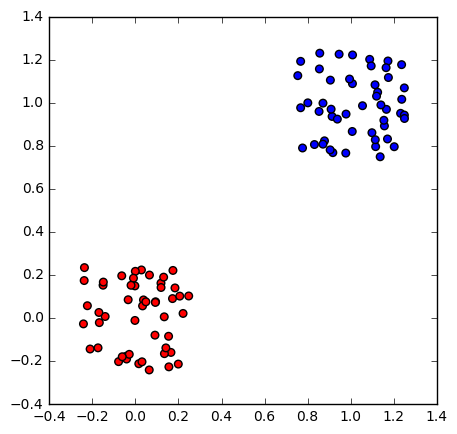

True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.555841971242
Training epoch: 100
MSE distance between input and reconstruction: 0.489652094818
Training epoch: 200
MSE distance between input and reconstruction: 0.427076523511
Training epoch: 300
MSE distance between input and reconstruction: 0.238563222251
Training epoch: 400
MSE distance between input and reconstruction: 0.17305270097
Training epoch: 500
MSE distance between input and reconstruction: 0.0562248413616
Training epoch: 600
MSE distance between input and reconstruction: 0.131499380991
Training epoch: 700
MSE distance between input and reconstruction: 0.112680876671
Training epoch: 800
MSE distance between input and reconstruction: 0.0527816866442
Training epoch: 900
MSE distance between input and reconstruction: 0.0490262869824
Training epoch: 1000
MSE distance between input and reconstruction

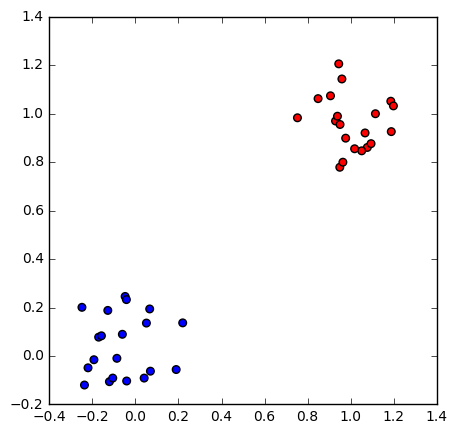

In [495]:
#WITH RBM

simple_train =np.array([[0.0, 0.0]] * 50 + [[1, 1.0]] * 50)
simple_check = np.array([[0.0]] * 50 + [[1.0]] * 50)

for i in xrange(len(simple_train)):
    (simple_train[i])[0] += np.random.sample() / 2 - 0.25
    (simple_train[i])[1] += np.random.sample() / 2 - 0.25
    
#на этих данных буду обучать
plt.figure(figsize = (5, 5))
plt.scatter(simple_train[:, 0], simple_train[:, 1],s = 30, \
            c = ['r' if simple_check[i][0] == 0 else 'b' for i in xrange(len(simple_check))])
plt.show() 

Layer1 = InputLayer(num_nodes = 2, bias = True)
Layer2 = OutputLayer(num_nodes = 1, prev_num_nodes = 2,bias = True,activate = 'sigmoid')

simple_model = DBN([Layer1, Layer2])
simple_model.fit(simple_train, simple_check, 20, 600, learning_ratio = 0.1,\
                 loss_function = "MSE", RBM_initialize = True)

print Layer2.weights_matrix
print Layer2.bias

#на этих тестировать 
simple_test =np.array([[0.0, 0]] * 20 + [[1, 1.0]] * 20)

for i in xrange(len(simple_test)):
    (simple_test[i])[0] += np.random.sample() / 2 - 0.25
    (simple_test[i])[1] += np.random.sample() / 2 - 0.25
    
simple_predict = simple_model.predict(simple_test)
print simple_predict
    
plt.figure(figsize = (5, 5))
plt.scatter(simple_test[:, 0], simple_test[:, 1],s = 30,\
            c = ['r' if simple_predict[i][0] > 0.5 else 'b' for i in xrange(len(simple_test))])
plt.show() 

## Двухслойный  DBN на XOR

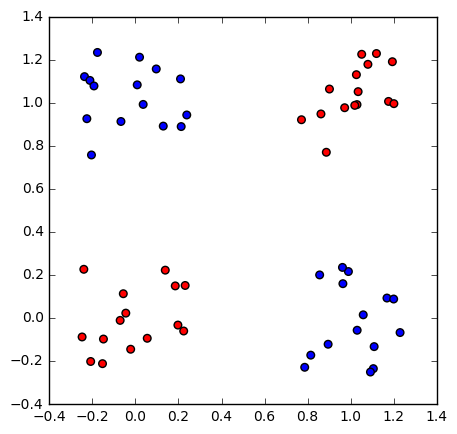

True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.496655187172
Training epoch: 100
MSE distance between input and reconstruction: 0.619600912152
Training epoch: 200
MSE distance between input and reconstruction: 0.566858482766
Training epoch: 300
MSE distance between input and reconstruction: 0.491502708362
Training epoch: 400
MSE distance between input and reconstruction: 0.41197555515
Training epoch: 500
MSE distance between input and reconstruction: 0.406307042607
Training epoch: 600
MSE distance between input and reconstruction: 0.371579007908
Training epoch: 700
MSE distance between input and reconstruction: 0.349409210567
Training epoch: 800
MSE distance between input and reconstruction: 0.415735273629
Training epoch: 900
MSE distance between input and reconstruction: 0.247235009979
Training epoch: 1000
MSE distance between input and reconstruction: 0

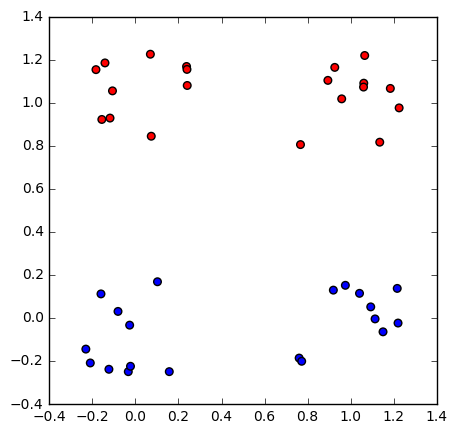

In [496]:
XOR_train = np.array([[0.0, 0]] * 15 + [[0.0, 1]] * 15 + [[1, 0.0]] * 15 + [[1, 1.0]] * 15)
XOR_check = np.array([[0.0]] * 15 + [[1.0]] *15 + [[1.0]] *15 + [[0.0]] *15)

for i in xrange(len(XOR_train)):
    (XOR_train[i])[0] += np.random.sample() / 2 - 0.25
    (XOR_train[i])[1] += np.random.sample() / 2 - 0.25
    
#на этих данных буду обучать
plt.figure(figsize = (5, 5))
plt.scatter(XOR_train[:, 0], XOR_train[:, 1], s = 30,\
            c = ['r' if XOR_check[i][0] == 0 else 'b' for i in xrange(len(XOR_check))])
plt.show()

inp = InputLayer(2)
outp = OutputLayer(1, prev_num_nodes=2, bias = True, activate = "sigmoid")

XOR_model = DBN(layers = [inp, outp])
XOR_model.fit(XOR_train, XOR_check, 30, 1000, learning_ratio = 0.01, loss_function = "MSE", RBM_initialize = True)

#на этих тестировать 
XOR_test =np.array([[0.0, 0]] * 10 + [[0.0, 1]] * 10 + [[1, 0.0]] * 10 + [[1, 1.0]] * 10)

for i in xrange(len(XOR_test)):
    (XOR_test[i])[0] += np.random.sample() / 2 - 0.25
    (XOR_test[i])[1] += np.random.sample() / 2 - 0.25
    
XOR_predict = XOR_model.predict(XOR_test)
print XOR_predict

plt.figure(figsize = (5, 5))
plt.scatter(XOR_test[:, 0], XOR_test[:, 1],s = 30, c = ['r' if XOR_predict[i][0] <= 0.5 else 'b' for i in xrange(len(XOR_predict))])
plt.show()  

## Обучение RBM c бинарными нейронами на MNIST

In [497]:
def read(dataset = "training", path = "/home/dana_zl/Technosphera/Neural_Network/"):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"
        
    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
        
    print img.shape
    print lbl, len(lbl)
    
    IMG = np.array([img[i].reshape(784) for i in xrange(len(lbl))])
    LBL = np.zeros((len(lbl), 10))
    for i in xrange(len(lbl)):
        LBL[i][lbl[i]] = 1
    
    return IMG, LBL


In [498]:
TRAIN_IMG, TRAIN_LBL = read(dataset = "training")
#TRAIN_IMG_NORM = sklearn.preprocessing.normalize(TRAIN_IMG, norm = 'max')
TRAIN_IMG_BIN = np.copy(TRAIN_IMG)
TRAIN_IMG_BIN[np.where(TRAIN_IMG_BIN > 0.0 )] = 1
print TRAIN_IMG_BIN.shape
print TRAIN_LBL.shape

(60000, 28, 28)
[5 0 4 ..., 5 6 8] 60000
(60000, 784)
(60000, 10)


In [499]:
print str(TRAIN_IMG[20007].reshape(28, 28))
print TRAIN_LBL[20007]
print str(TRAIN_IMG_BIN[20007].reshape(28, 28))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  15  24 118 138 139 138 138  97  24  22   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  57 219 252 252 252 253 252 252 252 252 245 140  13   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 253 252 252 252 252 253 252 252 252 252 253 252 171  13
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  56 160 160 160  56  46  45  45  45  98 211 252 252 139
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  34 25

In [500]:
MNIST_model = RBM(cnt_visible = 784, cnt_hidden = 144)
MNIST_model.fit(TRAIN_IMG_BIN, learning_ratio = 0.05, batch_size = 30, \
              training_epochs = 3000, momentum = 0.8, sampling_param = 2, verbose = 'MSE')

sdsd!
Training epoch: 0
MSE distance between input and reconstruction: 0.368197278912
Training epoch: 100
MSE distance between input and reconstruction: 0.108715986395
Training epoch: 200
MSE distance between input and reconstruction: 0.0861394557823
Training epoch: 300
MSE distance between input and reconstruction: 0.0712585034014
Training epoch: 400
MSE distance between input and reconstruction: 0.071981292517
Training epoch: 500
MSE distance between input and reconstruction: 0.0641156462585
Training epoch: 600
MSE distance between input and reconstruction: 0.0609268707483
Training epoch: 700
MSE distance between input and reconstruction: 0.062287414966
Training epoch: 800
MSE distance between input and reconstruction: 0.0563350340136
Training epoch: 900
MSE distance between input and reconstruction: 0.0555272108844
Training epoch: 1000
MSE distance between input and reconstruction: 0.0571853741497
Training epoch: 1100
MSE distance between input and reconstruction: 0.0652210884354
Tr

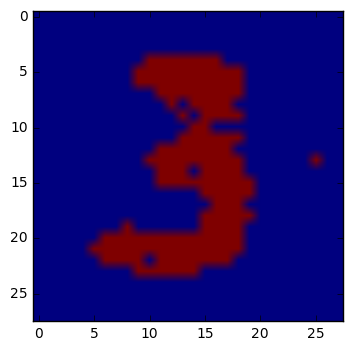

In [541]:
x = TRAIN_IMG_BIN[10]
y = MNIST_model.reconstruct([x])
plt.imshow(y.reshape(28, 28))

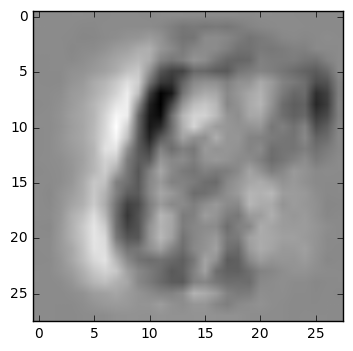

In [501]:
imgplot = plt.imshow(MNIST_model.weights[:, 10].reshape(28, 28), cmap=mpl.cm.Greys)

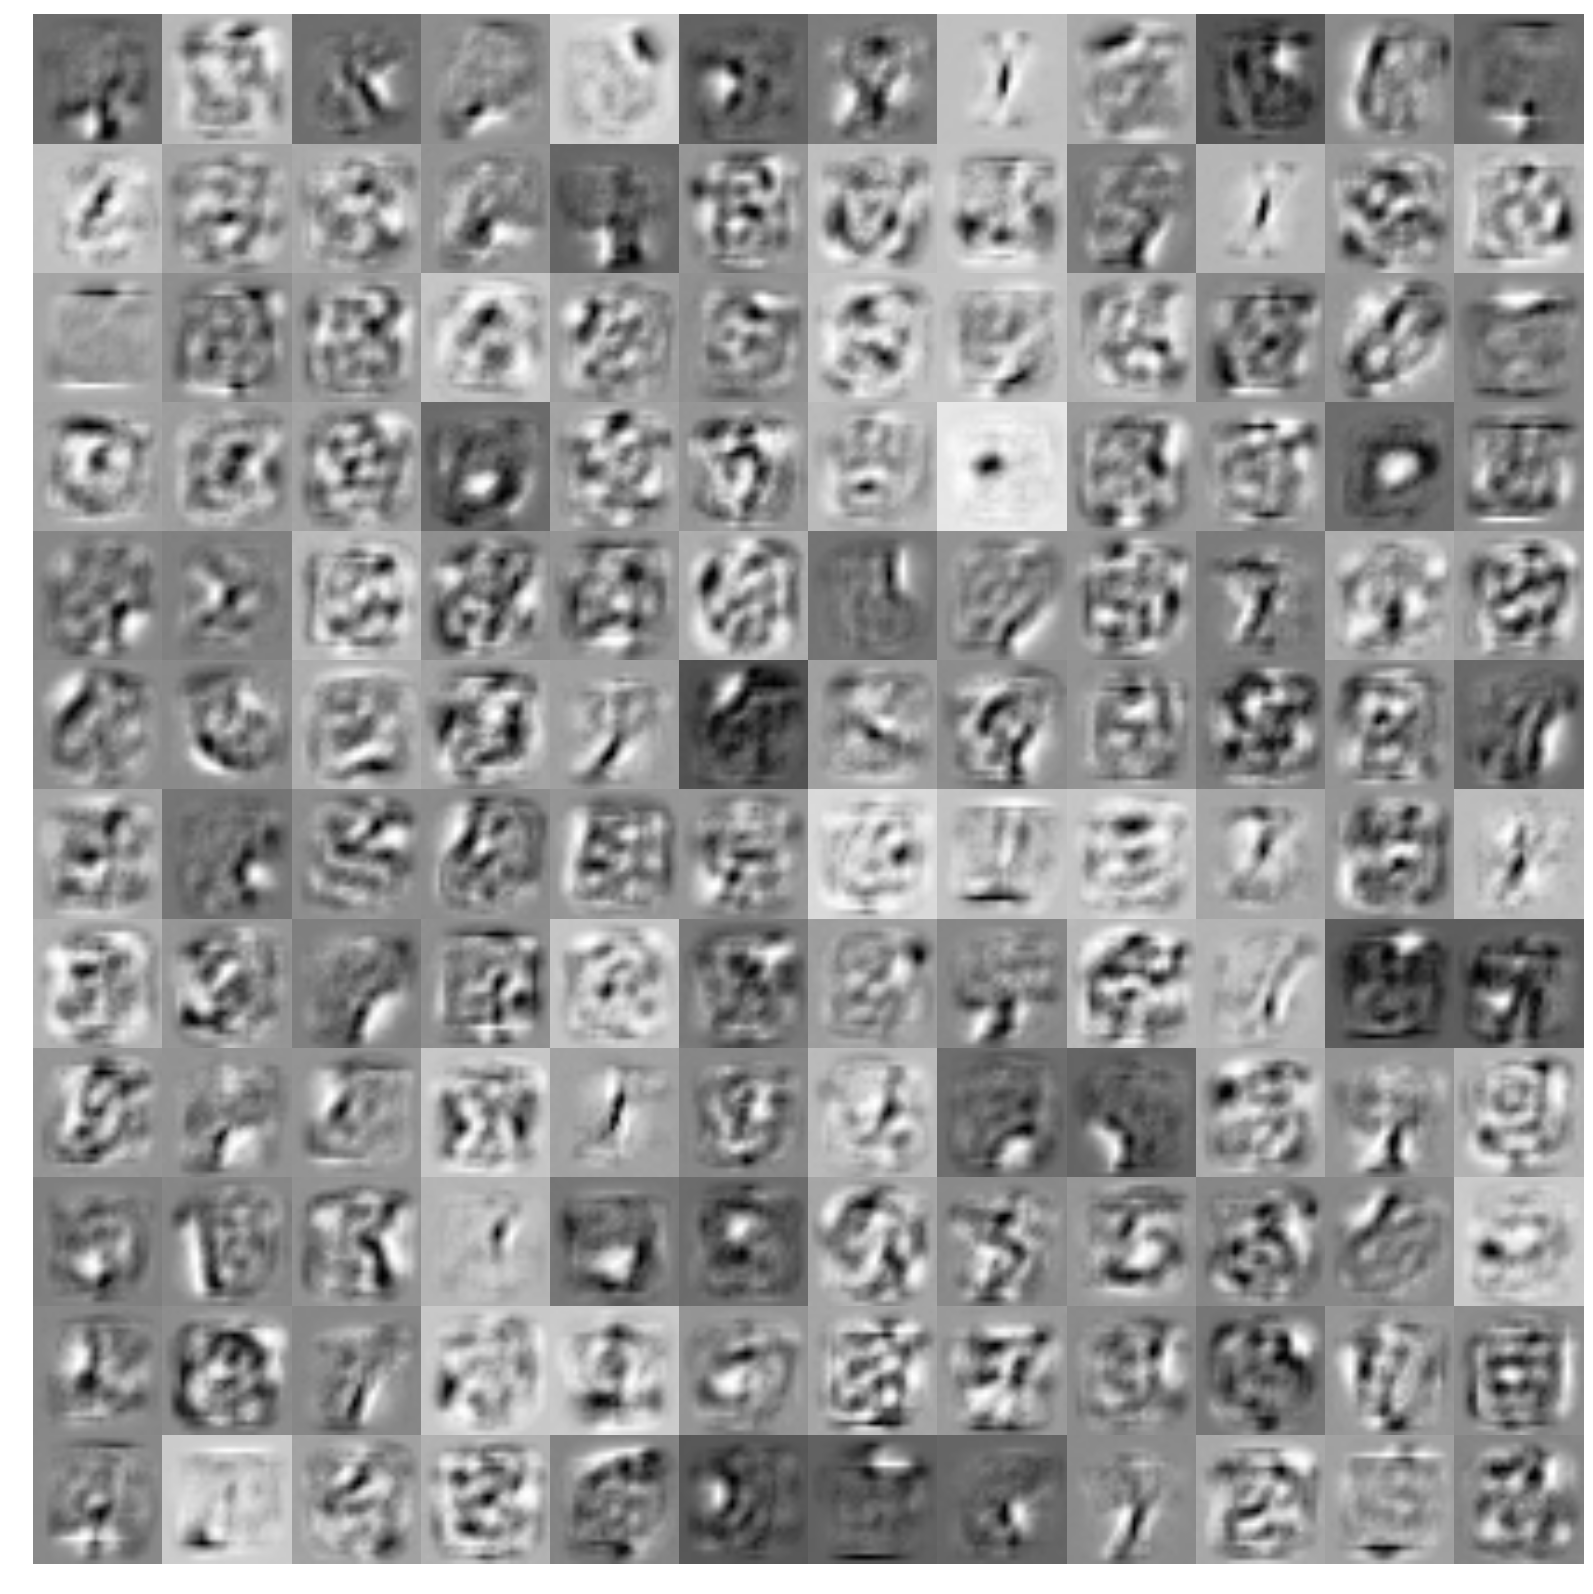

In [502]:
plt.figure(figsize = (20, 20))
plt.subplot(12,12,1)
for i in xrange(1, 13):
    for j in xrange(1, 13):
        plt.subplot(12, 12, (i-1) * 12 + j)
        plt.imshow(MNIST_model.weights[:, (i-1) * 12 + j - 1].reshape(28, 28), cmap=mpl.cm.Greys)
        plt.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)

# Enron Spam

In [503]:
import os

NEWLINE = '\n'
SKIP_FILES = {'cmds'}


def read_files(path):
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path)
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content

In [504]:
rows = []
index = []

HAM = 'ham'
SPAM = 'spam'

SOURCES = [
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/beck-s',      HAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/farmer-d',    HAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/kaminski-v',  HAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enrona/kitchen-l',  HAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/lokay-m',     HAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/williams-w3', HAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/BG',          SPAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/GP',          SPAM),
    ('/home/dana_zl/Technosphera/Neural_Network/Enron/SH',          SPAM)
]

for path, classification in SOURCES:
    for file_name, text in read_files(path):
        rows.append(text.decode("latin-1"))
        index.append(classification)


In [505]:
print len(index)
print len(rows)
print rows[1]

48064
48064
YEAR END 2000 PERFORMANCE EVALUATION FORMS ARE DUE IN HUMAN RESOURCES BY THE 

ABOVE DATE.  FOR EEL, THE DEADLINE IS JANUARY 31, 2001.



If you have not already done so, please begin the process of giving feedback 

to your employees.  The evaluation forms used to provide feedback to the 

employee can be obtained via the Performance Management System (PEP).



To download the evaluation forms from PEP, please follow the steps below:



1. Log into PEP at http://pep.corp.enron.com .

2. Under Supervisor Services, click Supervisor Evaluation Forms.

3. Right-click on each employee and choose 'Save Target As...' or 'Save Link 

As...'

4. Select your own personal directory, choose a file name to save to and 

click 'Save'.

5. Repeat for each employee.

6. Now you can complete your evaluation forms from your personal directory 

and will not have to access PEP to finalize the form.



Upon completion, please forward the signed evaluation forms to your HR 

Representative NO 

In [506]:
print rows[0] == rows[1]

False


In [4]:
import numpy as np
print np.asarray([1, 2, 3]).mean()

2.0


In [521]:
count_vectorizer = CountVectorizer(binary = True, analyzer="word", min_df = 0.02, max_df = 0.9)
counts = count_vectorizer.fit_transform(rows)

In [522]:
print counts.shape
print index[:10]
counts = counts.toarray()
print index[48063]

(48064, 800)
['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham']
spam


In [523]:
t= [1, 2]
labels = map(lambda x: 0 if x == 'ham' else 1 if x == "spam" else -1, index)
print np.asarray(labels).shape
labels = np.asarray(labels).reshape(-1, 1)
print labels[[1, 2, 48063]]

(48064,)
[[0]
 [0]
 [1]]


In [525]:
from sklearn.cross_validation import KFold
#запихивать параметры rbm в dbn!
k_fold = KFold(n=counts.shape[0], n_folds=10, shuffle=True)
scores = []
for train_indices, test_indices in k_fold:
    
    inp = InputLayer(counts.shape[1])
    l1 = Layer(num_nodes=200, prev_num_nodes = counts.shape[1], bias=True, activate="sigmoid")
    l2 = Layer(num_nodes=100, prev_num_nodes = 200, bias=True, activate="sigmoid")
#     l3 = Layer(num_nodes=2000, prev_num_nodes = 500, bias=True, activate="sigmoid")
    out = OutputLayer(num_nodes=1, prev_num_nodes = 100, bias=True, activate='sigmoid')
    
    ENRON_model = DBN(layers=[inp, l1,l2, out])
    ENRON_model.fit(counts[train_indices],
                    labels[train_indices], 30, 4000, \
                    learning_ratio = 0.1, loss_function = "MSE", RBM_initialize = True)
    break

True
True
True
True
____________________________________________________________
Train weights betweeen layer 0 and layer 1
Training epoch: 0
MSE distance between input and reconstruction: 0.267375
Training epoch: 100
MSE distance between input and reconstruction: 0.0821666666667
Training epoch: 200
MSE distance between input and reconstruction: 0.0845416666667
Training epoch: 300
MSE distance between input and reconstruction: 0.0575416666667
Training epoch: 400
MSE distance between input and reconstruction: 0.0652083333333
Training epoch: 500
MSE distance between input and reconstruction: 0.0517916666667
Training epoch: 600
MSE distance between input and reconstruction: 0.0425
Training epoch: 700
MSE distance between input and reconstruction: 0.0399583333333
Training epoch: 800
MSE distance between input and reconstruction: 0.0524583333333
Training epoch: 900
MSE distance between input and reconstruction: 0.0725416666667
Training epoch: 1000
MSE distance between input and reconstructi

In [526]:
model_res = ENRON_model.predict(counts[test_indices])

In [527]:
print model_res

[[  9.58449504e-02]
 [  2.92718174e-06]
 [  1.49423111e-05]
 ..., 
 [  1.00000000e+00]
 [  9.90496062e-01]
 [  1.00000000e+00]]


In [535]:
roc_auc = roc_auc_score(labels[test_indices], model_res)
print roc_auc

0.955196948356


In [529]:
fpr, tpr, thresholds = roc_curve(labels[test_indices], model_res)

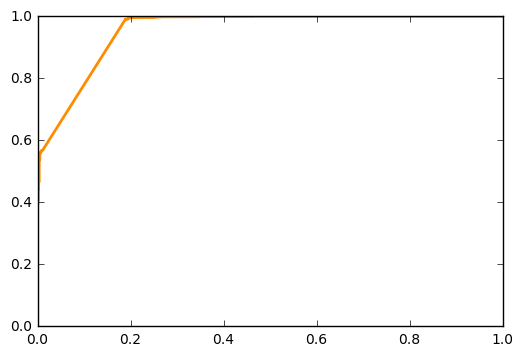

In [536]:
from sklearn.metrics import roc_curve, auc
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)